# Sparkify 项目 Workspace
这个 Workspace 包括一个迷你的子数据集（128MB），是完整数据集（12GB）的一个子集。在将你的项目部署到云上之前，你可以自由使用 Workspace 来创建你的项目或用Spark来探索这个较小数据集。设置 Spark 集群的指南可以在选修 Spark 课程的内容里找到。

你可以依照下面的步骤进行项目的数据分析和模型搭建部分。

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, avg, col, concat, desc, sort_array, asc, min, max, split, udf
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, Normalizer, StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder.appName('Mini Sparkify').getOrCreate()

# 加载和清洗数据
在这个 Workspace 中，小数据集的名称是 `mini_sparkify_event_data.json`。加载和清洗数据集，检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。 

In [3]:
df = spark.read.json('../spark/mini_sparkify_event_data.json')

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

## 清洗数据

### 处理缺失值

In [6]:
df.count()

286500

In [7]:
df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])
df.count()

286500

- 一共有286500条记录。

In [8]:
df.select('userId').dropDuplicates().sort('userId').show(5)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 5 rows



- 有些 userId 是空字符串。userId 为空字符串的原因可能有：未注册的用户、未登录账号的用户。

In [9]:
# 去掉 userId 为空字符串的记录
df = df.filter(df['userId'] != '')
df.count()

278154

- 另外，用户在不同的页面上会有不同的记录，比如在听歌的时候会有歌手信息、歌曲时长等，而在访问首页、修改设置的时候不会有歌手信息等记录。所以对于 artist 等字段，值为 None 是合理的，不是缺失值。

# 探索性数据分析
当你使用完整数据集时，通过加载小数据集，在 Spark 中完成基础操作来实现探索性数据分析。在这个 Workspace 中，我们已经提供给你一个你可以探索的小数据集。

### 定义客户流失

在你完成初步分析之后，创建一列 `Churn` 作为模型的标签。我建议你使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。作为一个奖励任务，你也可以深入了解 `Downgrade` 事件。

In [10]:
# page 的可能取值
df.groupBy('page').count().collect()

[Row(page='Cancel', count=52),
 Row(page='Submit Downgrade', count=63),
 Row(page='Thumbs Down', count=2546),
 Row(page='Home', count=10082),
 Row(page='Downgrade', count=2055),
 Row(page='Roll Advert', count=3933),
 Row(page='Logout', count=3226),
 Row(page='Save Settings', count=310),
 Row(page='Cancellation Confirmation', count=52),
 Row(page='About', count=495),
 Row(page='Settings', count=1514),
 Row(page='Add to Playlist', count=6526),
 Row(page='Add Friend', count=4277),
 Row(page='NextSong', count=228108),
 Row(page='Thumbs Up', count=12551),
 Row(page='Help', count=1454),
 Row(page='Upgrade', count=499),
 Row(page='Error', count=252),
 Row(page='Submit Upgrade', count=159)]

In [11]:
# 使用 Cancellation Confirmation 事件来定义客户流失。将有过该操作的用户定义为流失用户。
# 生成流失用户列表
churn_users = df.filter(df['page'] == 'Cancellation Confirmation').select('userId').dropDuplicates()
churn_users_list = [user['userId'] for user in churn_users.collect()]
churn_users_list[:5]

['125', '51', '54', '100014', '101']

In [12]:
# 增加一列，标记流失，True 代表流失，False 代表没有流失
df_churn = df.withColumn('churn', df['userId'].isin(churn_users_list))
df_churn.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=False)

In [13]:
# 流失用户占比
churn_users_num = len(churn_users_list)
total_users_num = df_churn.select('userId').dropDuplicates().count()

print('总用户：{} 人，其中流失用户：{} 人，占总用户数的：{:0.1f}%' \
      .format(total_users_num, churn_users_num, 100*churn_users_num/total_users_num))

总用户：225 人，其中流失用户：52 人，占总用户数的：23.1%


### 探索数据
你定义好客户流失后，就可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

In [14]:
# 分类变量可能取值（暂时不考虑变量：'artist', 'firstName', 'lastName', 'location', 'song', 'userAgent'）
nominal_var_lists = ['auth', 'gender', 'level', 'method', 'page', 'status']
for var in nominal_var_lists:
    print(var, ':', [x[var] for x in df_churn.select(var).dropDuplicates().collect()])

auth : ['Cancelled', 'Logged In']
gender : ['F', 'M']
level : ['free', 'paid']
method : ['PUT', 'GET']
page : ['Cancel', 'Submit Downgrade', 'Thumbs Down', 'Home', 'Downgrade', 'Roll Advert', 'Logout', 'Save Settings', 'Cancellation Confirmation', 'About', 'Settings', 'Add to Playlist', 'Add Friend', 'NextSong', 'Thumbs Up', 'Help', 'Upgrade', 'Error', 'Submit Upgrade']
status : [307, 404, 200]


In [15]:
df_churn.describe(['length']).show()

+-------+------------------+
|summary|            length|
+-------+------------------+
|  count|            228108|
|   mean|249.11718197783583|
| stddev| 99.23517921058313|
|    min|           0.78322|
|    max|        3024.66567|
+-------+------------------+



#### 留存用户和流失用户之间的对比

1. 人口统计学特征对比

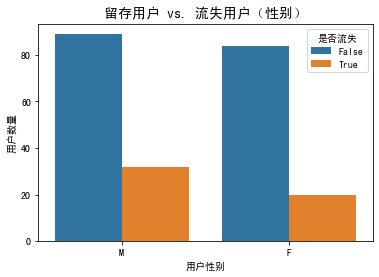

In [16]:
# 1.1 性别
gender_df = df_churn.select(['userId', 'gender', 'churn']).dropDuplicates().toPandas()

ax = sb.countplot(data=gender_df, x='gender', hue='churn')
plt.xlabel('用户性别', fontsize=10)
plt.ylabel('用户数量', fontsize=10)
plt.title('留存用户 vs. 流失用户（性别）', fontsize=14)
ax.legend(title='是否流失')
plt.show()

In [17]:
churn_gender_M_num = df_churn.filter((df_churn['gender'] == 'M') & (df_churn['churn'] == 'True')) \
                .select('userId').dropDuplicates().count()
churn_gender_F_num = df_churn.filter((df_churn['gender'] == 'F') & (df_churn['churn'] == 'True')) \
                .select('userId').dropDuplicates().count()

gender_M_num = df_churn.filter(df_churn['gender'] == 'M').select('userId').dropDuplicates().count()
gender_F_num = df_churn.filter(df_churn['gender'] == 'F').select('userId').dropDuplicates().count()

print('男性用户流失比例为：{:0.1f}%，女性用户流失比例为：{:0.1f}%。' \
      .format(100*churn_gender_M_num/gender_M_num, 100*churn_gender_F_num/gender_F_num))

男性用户流失比例为：26.4%，女性用户流失比例为：19.2%。


In [18]:
# 1.2 所在地
get_state = udf(lambda x: x[-2:])

state_df = df_churn.select('userId', 'location', 'churn') \
        .withColumn('locationstate', get_state(df_churn['location'])) \
        .dropDuplicates() \
        .toPandas()

state_df.head()

,userId,location,churn,locationstate
0,113,"Charlotte-Concord-Gastonia, NC-SC",False,SC
1,47,"Columbus, GA-AL",False,AL
2,156,"Scranton--Wilkes-Barre--Hazleton, PA",False,PA
3,200015,"San Diego-Carlsbad, CA",True,CA
4,129,"Flint, MI",True,MI


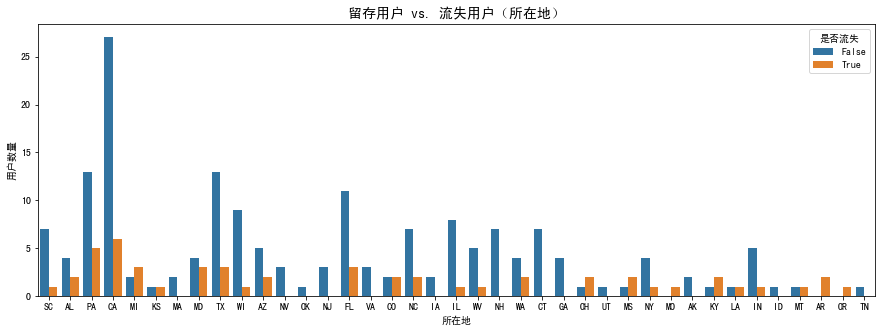

In [19]:
plt.figure(figsize = [15, 5])
ax = sb.countplot(data=state_df, x='locationstate', hue='churn')
plt.xlabel('所在地', fontsize=10)
plt.ylabel('用户数量', fontsize=10)
plt.title('留存用户 vs. 流失用户（所在地）', fontsize=14)
ax.legend(loc='upper right', title='是否流失')
plt.show()

- 不同的地区流失率不同。不过由于所在地的种类较多，需要聚合成大一级的区域进一步分析。

2. 应用使用情况对比

In [20]:
# 2.1 注册日期（年月）
get_yearmonth = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%Y%m'))

reg_df = df_churn.select('userId', 'registration', 'churn') \
        .withColumn('yearmonth', get_yearmonth(df_churn['registration'])) \
        .dropDuplicates() \
        .toPandas()

reg_df.head()

,userId,registration,churn,yearmonth
0,7,1536667576000,False,201809
1,200024,1537897424000,True,201809
2,200005,1533532298000,False,201808
3,16,1536597540000,False,201809
4,118,1537893493000,False,201809


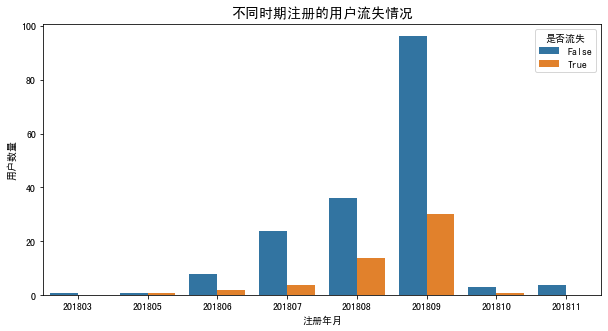

In [21]:
plt.figure(figsize = [10, 5])
ax = sb.countplot(data=reg_df, x='yearmonth', hue='churn')
plt.xlabel('注册年月', fontsize=10)
plt.ylabel('用户数量', fontsize=10)
plt.title('不同时期注册的用户流失情况', fontsize=14)
ax.legend(loc='upper right', title='是否流失')
plt.show()

- 很多月份只有几个注册用户，因此不同注册月份的用户流失比例相差较大。

In [22]:
# 2.2 是否付费（用户等级）
# 生成有付费行为的用户列表
paid_users = df.filter(df['level'] == 'paid').select('userId').dropDuplicates()
paid_users_list = [user['userId'] for user in paid_users.collect()]
len(paid_users_list)

165

In [23]:
level_df = df_churn.select('userId', 'churn') \
        .withColumn('has_paid', df_churn['userId'].isin(paid_users_list)) \
        .dropDuplicates() \
        .toPandas()

level_df.head()

,userId,churn,has_paid
0,109,False,True
1,70,True,True
2,83,False,True
3,300011,False,True
4,68,False,False


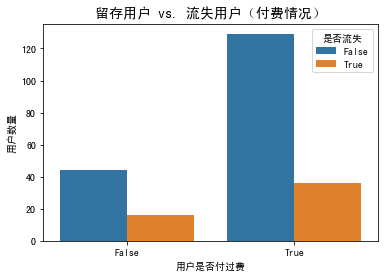

In [24]:
ax = sb.countplot(data=level_df, x='has_paid', hue='churn')
plt.xlabel('用户是否付过费', fontsize=10)
plt.ylabel('用户数量', fontsize=10)
plt.title('留存用户 vs. 流失用户（付费情况）', fontsize=14)
ax.legend(loc='upper right', title='是否流失')
plt.show()

In [25]:
churn_paid_T_num = sum(level_df['has_paid'].loc[level_df['churn'] == True])
paid_T_num = len(paid_users_list)

churn_paid_F_num = sum(~level_df['has_paid'].loc[level_df['churn'] == True])
paid_F_num = level_df.shape[0] - paid_T_num

print('没有过消费的用户流失比例为：{:0.1f}%，有过消费的用户流失比例为：{:0.1f}%。'\
      .format(100*churn_paid_F_num/paid_F_num, 100*churn_paid_T_num/paid_T_num))

没有过消费的用户流失比例为：26.7%，有过消费的用户流失比例为：21.8%。


In [26]:
# 2.3 访问不同页面的次数
# 生成用户-页面关系矩阵
user_page = df_churn.groupBy(['userId']).pivot('page').count().fillna(0).toPandas()
# 重新命名用来定义流失的列
user_page = user_page.rename(columns={'Cancellation Confirmation': 'Churn'})
user_page.head()

,userId,About,Add Friend,Add to Playlist,Cancel,Churn,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,200002,3,4,8,0,0,5,0,2,20,5,387,7,0,3,0,1,6,21,2
1,100010,1,4,7,0,0,0,0,2,11,5,275,52,0,0,0,0,5,17,2
2,125,0,0,0,1,1,0,0,0,0,0,8,1,0,0,0,0,0,0,0
3,51,2,28,52,1,1,23,1,12,75,24,2111,0,1,12,0,0,21,100,0
4,124,7,74,118,0,0,41,6,23,176,59,4079,4,6,20,0,0,41,171,0


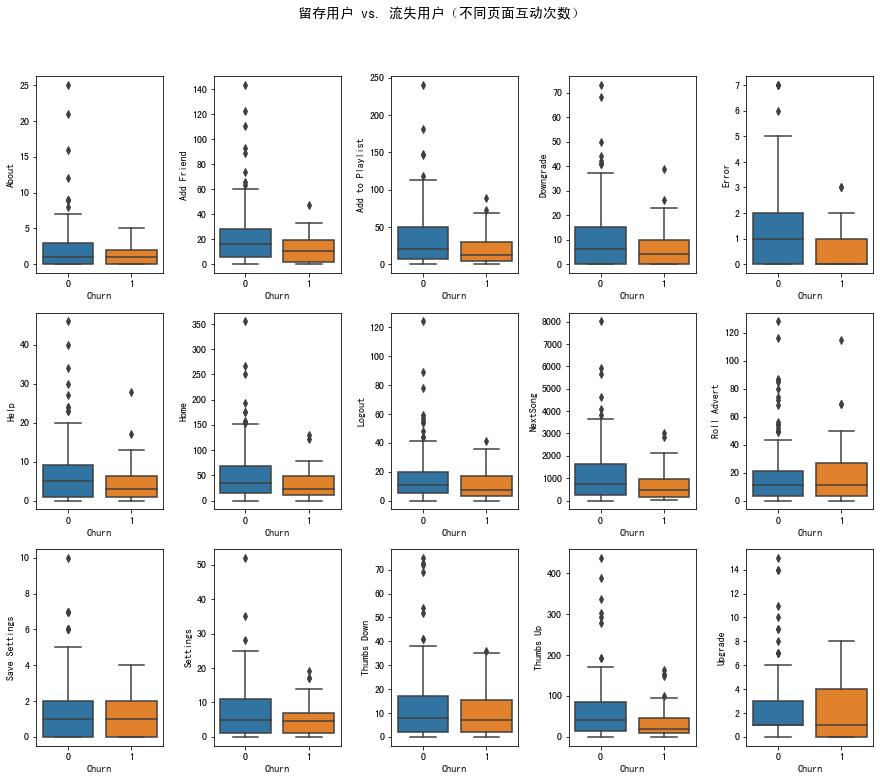

In [27]:
# 不同页面互动次数 vs. 是否流失
c_variables = ['About', 'Add Friend', 'Add to Playlist', 'Downgrade', 'Error', 'Help', 'Home', 'Logout', 
               'NextSong', 'Roll Advert', 'Save Settings', 'Settings', 'Thumbs Down', 'Thumbs Up', 'Upgrade']

subCnt = 1  # 初始化子图标号
fig = plt.figure(figsize=(15, 12))

for var in c_variables:
    fig.add_subplot(3, 5, subCnt)
    sb.boxplot(data=user_page, x='Churn', y=var)
    subCnt = subCnt + 1
    
fig.suptitle('留存用户 vs. 流失用户（不同页面互动次数）', fontsize=14)
fig.subplots_adjust(top=.9, wspace=.4)
plt.show()

从图中展现的数据，我觉得可以将页面大致分为3类：

1. 对用户留存有正面效果的页面：'Add Friend'（形成一个社交圈以及社交活动可以促进用户的留存）, 'Add to Playlist'（生成自己个性化的播放列表）, 'Thumbs Up'（表达喜欢、满意）, 'NextSong'（听歌的次数）, 'Help'（用户和网站的互动）。
2. 对用户留存有中性效果的页面：'About', 'Home', 'Logout', 'Error', 'Save Settings', 'Settings'。由于留存用户要比流失用户使用的时间、频次更多，所以有更多机会遇到这些页面。于是虽然这些页面不直接反映用户偏好，但是留存用户的次数要比流失用户的次数多。
3. 对用户留存有负面效果的页面：'Roll Advert'（一般广告会带来一些负面效果）, 'Thumbs Down'（表达不喜欢）。

另外，不清楚'Downgrade'和'Upgrade'的具体含义，所以暂时先不考虑，以后改进的时候再考虑。

In [28]:
# 2.4 注册到最后一次记录的天数
lifetime_df = df_churn.select('userId', 'registration', 'ts', 'churn') \
        .withColumn('lifetime',(df_churn.ts-df_churn.registration)) \
        .groupBy('userId', 'churn') \
        .agg({'lifetime':'max'}) \
        .withColumnRenamed('max(lifetime)', 'lifetime') \
        .toPandas()

lifetime_df['lifetime'] = lifetime_df['lifetime'] / (1000*3600*24)
lifetime_df.head()

,userId,churn,lifetime
0,19,False,21.451435
1,100005,True,85.195590
2,200007,False,53.397743
3,300007,True,11.553704
4,50,False,75.447106


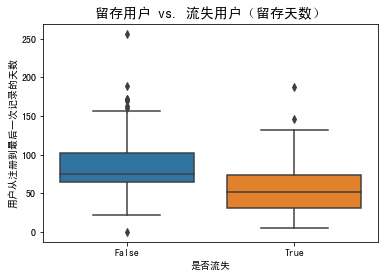

In [29]:
ax = sb.boxplot(data=lifetime_df, x='churn', y='lifetime')
plt.xlabel('是否流失', fontsize=10)
plt.ylabel('用户从注册到最后一次记录的天数', fontsize=10)
plt.title('留存用户 vs. 流失用户（留存天数）', fontsize=14)
plt.show()

In [30]:
# 2.5 每个用户互动的次数
session_df = df_churn.select('userId', 'sessionId', 'churn').dropDuplicates() \
        .groupby('userId', 'churn').count() \
        .withColumnRenamed('count', 'sessioncount') \
        .toPandas()
session_df.head()

,userId,churn,sessioncount
0,19,False,1
1,200007,False,3
2,100005,True,5
3,300007,True,1
4,50,False,8


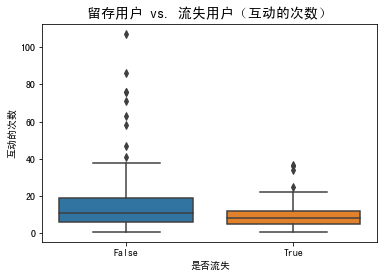

In [31]:
ax = sb.boxplot(data=session_df, x='churn', y='sessioncount')
plt.xlabel('是否流失', fontsize=10)
plt.ylabel('互动的次数', fontsize=10)
plt.title('留存用户 vs. 流失用户（互动的次数）', fontsize=14)
plt.show()

In [32]:
# 2.6 平均每个 session 听多少首歌
user_session_songs_df = df_churn.select('userID', 'sessionId', 'page', 'churn') \
                .filter(df_churn['page'] == 'NextSong') \
                .groupby('userId', 'churn', 'sessionId') \
                .agg({'page': 'count'}) \
                .groupby('userId', 'churn') \
                .agg({'count(page)': 'avg'}) \
                .withColumnRenamed('avg(count(page))', 'avg_songs') \
                .toPandas()
    
user_session_songs_df.head()         

,userId,churn,avg_songs
0,19,False,216.0
1,100005,True,38.5
2,300007,True,111.0
3,200007,False,32.5
4,200002,False,64.5


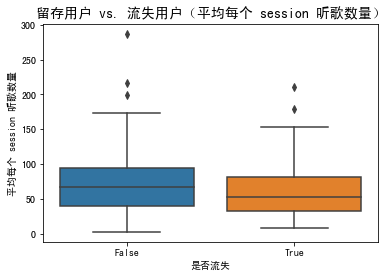

In [33]:
ax = sb.boxplot(data=user_session_songs_df, x='churn', y='avg_songs')
plt.xlabel('是否流失', fontsize=10)
plt.ylabel('平均每个 session 听歌数量', fontsize=10)
plt.title('留存用户 vs. 流失用户（平均每个 session 听歌数量）', fontsize=14)
plt.show()

In [34]:
# 2.7 每个用户听过的歌手的数量（去重）
artist_df = df_churn.select('userId', 'artist', 'churn').dropDuplicates() \
        .filter(df_churn['page'] == 'NextSong') \
        .groupby('userId', 'churn').count() \
        .withColumnRenamed('count', 'artistcount') \
        .toPandas()

artist_df.head()

,userId,churn,artistcount
0,19,False,197
1,200007,False,64
2,100005,True,149
3,300007,True,107
4,200002,False,339


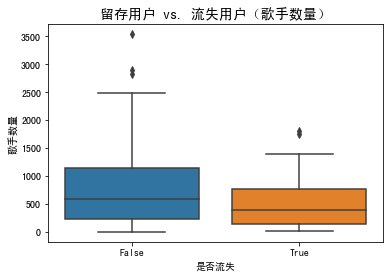

In [35]:
ax = sb.boxplot(data=artist_df, x='churn', y='artistcount')
plt.xlabel('是否流失', fontsize=10)
plt.ylabel('歌手数量', fontsize=10)
plt.title('留存用户 vs. 流失用户（歌手数量）', fontsize=14)
plt.show()

# 特征工程
熟悉了数据之后，就可以构建你认为会对训练模型帮助最大的特征。要处理完整数据集，你可以按照下述步骤：
- 写一个脚本来从小数据集中提取你需要的特征
- 确保你的脚本可以拓展到大数据集上，使用之前教过的最佳实践原则
- 在完整数据集上运行你的脚本，按运行情况调试代码

如果是在教室的 workspace，你可以直接用里面提供的小数据集来提取特征。确保当你开始使用 Spark 集群的时候，把上述的成果迁移到大数据集上。

在上面的探索性分析后，决定选取以下特征，共有10个。
- churn：是否流失，1: 流失，0: 未流失
- gender：性别，1: male，0: female
- friendcount：加好友次数
- playlistcount：加播放列表次数
- advertcount：看到广告次数
- upcount：喜欢的次数
- downcount：不喜欢的次数
- lifetime：注册到最后一次记录的天数
- avg_songs：平均每个 session 听多少首歌
- artistcount：用户听过的歌曲的歌手数量（去重）

In [36]:
df_churn.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=False)

In [37]:
f1_churn = df_churn.select('userId', 'churn').dropDuplicates() \
        .replace(['False', 'True'], ['0', '1'], 'churn') \
        .select('userId', col('churn').cast('int'))

f1_churn.show(5)

+------+-----+
|userId|churn|
+------+-----+
|    19|    0|
|100005|    1|
|200007|    0|
|300007|    1|
|    50|    0|
+------+-----+
only showing top 5 rows



In [38]:
f2_gender = df_churn.select('userId', 'gender').dropDuplicates() \
        .replace(['F', 'M'], ['0', '1'], 'gender') \
        .select('userId', col('gender').cast('int'))

f2_gender.show(5)

+------+------+
|userId|gender|
+------+------+
|    44|     0|
|    46|     0|
|    41|     0|
|    72|     0|
|300023|     0|
+------+------+
only showing top 5 rows



In [83]:
f3_friendcount = df_churn.select('userId', 'page') \
        .where(df_churn['page'] == 'Add Friend') \
        .groupBy('userId') \
        .count() \
        .withColumnRenamed('count', 'friendcount')

f3_friendcount.show(5)

+------+-----------+
|userId|friendcount|
+------+-----------+
|100010|          4|
|200002|          4|
|    51|         28|
|   124|         74|
|     7|          1|
+------+-----------+
only showing top 5 rows



In [84]:
f4_playlistcount = df_churn.select('userId', 'page') \
        .where(df_churn['page'] == 'Add to Playlist') \
        .groupBy('userId') \
        .count() \
        .withColumnRenamed('count', 'playlistcount')

f4_playlistcount.show(5)

+------+-------------+
|userId|playlistcount|
+------+-------------+
|100010|            7|
|200002|            8|
|    51|           52|
|   124|          118|
|     7|            5|
+------+-------------+
only showing top 5 rows



In [85]:
f5_advertcount = df_churn.select('userId', 'page') \
        .where(df_churn['page'] == 'Roll Advert') \
        .groupBy('userId') \
        .count() \
        .withColumnRenamed('count', 'advertcount')

f5_advertcount.show(5)

+------+-----------+
|userId|advertcount|
+------+-----------+
|100010|         52|
|200002|          7|
|   125|          1|
|     7|         16|
|   124|          4|
+------+-----------+
only showing top 5 rows



In [86]:
f6_upcount = df_churn.select('userId', 'page') \
        .where(df_churn['page'] == 'Thumbs Up') \
        .groupBy('userId') \
        .count() \
        .withColumnRenamed('count', 'upcount')

f6_upcount.show(5)

+------+-------+
|userId|upcount|
+------+-------+
|100010|     17|
|200002|     21|
|    51|    100|
|   124|    171|
|     7|      7|
+------+-------+
only showing top 5 rows



In [87]:
f7_downcount = df_churn.select('userId', 'page') \
        .where(df_churn['page'] == 'Thumbs Down') \
        .groupBy('userId') \
        .count() \
        .withColumnRenamed('count', 'downcount')

f7_downcount.show(5)

+------+---------+
|userId|downcount|
+------+---------+
|100010|        5|
|200002|        6|
|    51|       21|
|   124|       41|
|     7|        1|
+------+---------+
only showing top 5 rows



In [88]:
f8_lifetime = df_churn.select('userId', 'registration', 'ts') \
        .withColumn('lifetime', (df_churn['ts']-df_churn['registration'])) \
        .groupBy('userId') \
        .agg({'lifetime':'max'}) \
        .withColumnRenamed('max(lifetime)', 'lifetime') \
        .select('userId', (col('lifetime')/(1000*3600*24)).alias('lifetime'))

f8_lifetime.show(5)

+------+------------------+
|userId|          lifetime|
+------+------------------+
|100010| 55.64365740740741|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|    51|19.455844907407407|
|   124|131.55591435185184|
+------+------------------+
only showing top 5 rows



In [89]:
f9_avgsongs = df_churn.select('userID', 'sessionId', 'page') \
            .filter(df_churn['page'] == 'NextSong') \
            .groupby('userId', 'sessionId') \
            .agg({'page': 'count'}) \
            .groupby('userId') \
            .agg({'count(page)': 'avg'}) \
            .withColumnRenamed('avg(count(page))', 'avgsongs') 

f9_avgsongs.show(5)

+------+------------------+
|userId|          avgsongs|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
+------+------------------+
only showing top 5 rows



In [90]:
f10_artistcount = df_churn.select('userId', 'artist').dropDuplicates() \
        .filter(df_churn['page'] == 'NextSong') \
        .groupby('userId').count() \
        .withColumnRenamed('count', 'artistcount') \

f10_artistcount.show(5)

+------+-----------+
|userId|artistcount|
+------+-----------+
|100010|        252|
|200002|        339|
|   125|          8|
|   124|       2232|
|    51|       1385|
+------+-----------+
only showing top 5 rows



In [93]:
df_all = f1_churn.join(f2_gender, ['userId']) \
    .join(f3_friendcount, ['userId']) \
    .join(f4_playlistcount, ['userId']) \
    .join(f5_advertcount, ['userId']) \
    .join(f6_upcount, ['userId']) \
    .join(f7_downcount, ['userId']) \
    .join(f8_lifetime, ['userId']) \
    .join(f9_avgsongs, ['userId']) \
    .join(f10_artistcount, ['userId']) \
    .drop('userId') \
    .fillna(0)

df_all.head()

Row(churn=0, gender=0, friendcount=4, playlistcount=7, advertcount=52, upcount=17, downcount=5, lifetime=55.64365740740741, avgsongs=39.285714285714285, artistcount=252)

# 建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

In [95]:
# 向量化
cols = ['gender', 'friendcount', 'playlistcount', 'advertcount', 
        'upcount', 'downcount', 'lifetime', 'avgsongs', 'artistcount']
assembler = VectorAssembler(inputCols=cols, outputCol='NumFeatures')
data = assembler.transform(df_all)
data.head()

Row(churn=0, gender=0, friendcount=4, playlistcount=7, advertcount=52, upcount=17, downcount=5, lifetime=55.64365740740741, avgsongs=39.285714285714285, artistcount=252, NumFeatures=DenseVector([0.0, 4.0, 7.0, 52.0, 17.0, 5.0, 55.6437, 39.2857, 252.0]))

In [96]:
# 标准化
scaler = StandardScaler(inputCol='NumFeatures', outputCol='features', withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)
data.head()

Row(churn=0, gender=0, friendcount=4, playlistcount=7, advertcount=52, upcount=17, downcount=5, lifetime=55.64365740740741, avgsongs=39.285714285714285, artistcount=252, NumFeatures=DenseVector([0.0, 4.0, 7.0, 52.0, 17.0, 5.0, 55.6437, 39.2857, 252.0]), features=DenseVector([0.0, 0.1875, 0.2052, 2.2765, 0.2472, 0.3681, 1.4951, 1.0053, 0.4191]))

In [97]:
data_model = data.select(data['churn'].alias('label'), data['features'])
data_model.head()

Row(label=0, features=DenseVector([0.0, 0.1875, 0.2052, 2.2765, 0.2472, 0.3681, 1.4951, 1.0053, 0.4191]))

### 将数据集分成训练集、测试集和验证集

In [98]:
# 训练集：测试集：验证集 = 60%：20%：20%
train, rest = data_model.randomSplit([0.6, 0.4], seed=42)
test, validation = rest.randomSplit([0.5, 0.5], seed=42)

### 建模
在 Spark 支持的分类算法中选择 Logistic Regression、Gradient Boosted Tree 和 Random Forest 建模。

- Logistic Regression：选择该算法是因为它实施起来简单（线性），但是效果一般也不会太差。
- Gradient Boosted Tree：应用广泛，拟合效果好，结果有解释性。
- Random Forest：也是基于决策树的模型，可以应用在大数据集上。

下面先针对这两个算法分别建模，然后选择效果好的算法调参，得到最优的模型。

In [99]:
# 因为流失顾客数据集很小，所以选用 F1 score 作为优化指标。
f1_score = MulticlassClassificationEvaluator(metricName='f1')

#### Logistic Regression

In [100]:
lr = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

In [101]:
# build paramGrid
paramGrid = ParamGridBuilder().build()

crossval_lr = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=f1_score, numFolds=3)

In [102]:
lrModel = crossval_lr.fit(train)

In [116]:
lrtest = lrModel.transform(test)

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
print('Logistic Regression:')
print('Accuracy: {}'.format(evaluator.evaluate(lrtest, {evaluator.metricName: 'accuracy'})))
print('F1 Score: {}'.format(evaluator.evaluate(lrtest, {evaluator.metricName: 'f1'})))

Logistic Regression:
Accuracy: 0.375
F1 Score: 0.34523809523809523


#### Gradient Boosted Tree

In [104]:
gbt = GBTClassifier(seed=42)

In [105]:
crossval_gbt = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=f1_score, numFolds=3)

In [106]:
gbtModel = crossval_gbt.fit(train)

In [107]:
gbttest = gbtModel.transform(test)

In [108]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
print('Gradient Boosted Tree:')
print('Accuracy: {}'.format(evaluator.evaluate(gbttest, {evaluator.metricName: 'accuracy'})))
print('F1 Score: {}'.format(evaluator.evaluate(gbttest, {evaluator.metricName: 'f1'})))

Gradient Boosted Tree:
Accuracy: 0.625
F1 Score: 0.6071428571428572


#### Random Forest

In [109]:
rf = RandomForestClassifier(seed=42)
crossval_rf = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=f1_score, numFolds=3)

rfModel = crossval_rf.fit(train)

In [117]:
rftest = rfModel.transform(test)

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
print('Random Forest:')
print('Accuracy: {}'.format(evaluator.evaluate(rftest, {evaluator.metricName: 'accuracy'})))
print('F1 Score: {}'.format(evaluator.evaluate(rftest, {evaluator.metricName: 'f1'})))

Random Forest:
Accuracy: 0.5
F1 Score: 0.43333333333333335


- Gradient Boosted Tree 的效果最好，F1 score 为 0.607。所以下面调参的时候选用该模型。

#### 调参

In [111]:
gbt = GBTClassifier(seed=42)

# build paramGrid
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth,[4, 5]) \
    .addGrid(gbt.maxIter,[10, 15]) \
    .build()

crossval_tuned = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid_gbt, evaluator=f1_score, numFolds=3)

In [112]:
Model_tuned = crossval_tuned.fit(train)
Model_tuned.avgMetrics

[0.7425934604347453,
 0.7425934604347453,
 0.7195741194053634,
 0.7195741194053634]

In [113]:
# 最好的模型
gbt_best = GBTClassifier(seed=42, maxDepth=4, maxIter=10)
gbt_best_model = gbt_best.fit(train)
gbt_best_result = gbt_best_model.transform(validation)

In [114]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
print('Best Model:')
print('Accuracy: {}'.format(evaluator.evaluate(gbt_best_result, {evaluator.metricName: 'accuracy'})))
print('F1 Score: {}'.format(evaluator.evaluate(gbt_best_result, {evaluator.metricName: 'f1'})))

Best Model:
Accuracy: 0.8125
F1 Score: 0.8173214285714285


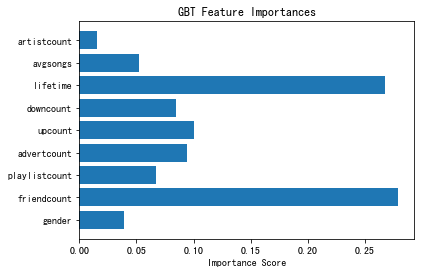

In [115]:
# 特征重要性
importances = gbt_best_model.featureImportances.values
cols = ['gender', 'friendcount', 'playlistcount', 'advertcount', 
        'upcount', 'downcount', 'lifetime', 'avgsongs', 'artistcount']
y = np.arange(len(cols))
 
plt.barh(y, importances, align='center')
plt.yticks(y, cols)
plt.xlabel('Importance Score')
plt.title('GBT Feature Importances');

从图上看，“用户的留存时间”和“朋友数量”是比较重要的特征。“朋友数量”这个特征说明了社交圈对于一个APP用户的留存有影响。所以，有些应用会和社交APP合作，使用第三方的社交账号登陆应用，可能也有这方面的好处。

# 最后一步
清理你的代码，添加注释和重命名变量，使得代码更易读和易于维护。参考 Spark 项目概述页面和数据科学家毕业项目审阅要求，确保你的项目包含了毕业项目要求的所有内容，并且满足所有审阅要求。记得在 GitHub 代码库里包含一份全面的文档——README文件，以及一个网络应用程序或博客文章。